# Analysis pipeline

## Step 1: Load Libraries and dataset

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples
from matplotlib import cm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Load dataset
df = pd.read_csv("/Users/matildeelene/Desktop/Social_Cultural/AI_companions/SocCult_data/combined_reviews_final.csv")
len(df)

8528

## Step 2: Create Subgroups based on 'support_types'

We filter the dataset into three predefined subgroups based on the application of a a rule-based hierarchy.
- **Therapist** (2)
- **Partner** (1)
- **Friend** (3)

In [11]:
# Therapist = "Therapeutic Conversation"
# Partner = "Significant Other Relationship"
# Friend = "Friendship"

import ast
# STEP 2: Convert the 'support_types' string to a list
df['support_types'] = df['support_types'].apply(lambda x: [s.strip() for s in x.split(',')] if isinstance(x, str) else [])

# STEP 3: Define your hard-labeling function
def assign_primary_support_type(support_types):
    if 'Significant Other Relationship' in support_types:
        return 'partner'
    elif 'Therapeutic Conversation' in support_types:
        return 'therapist'
    elif 'Friendship' in support_types:
        return 'friend'
    else:
        return 'other'

# STEP 4: Apply the labeling
df['primary_support_type'] = df['support_types'].apply(assign_primary_support_type)

# STEP 5: Filter to keep only the 3 groups
df_filtered = df[df['primary_support_type'].isin(['therapist', 'partner', 'friend'])]

# STEP 6: Save new dataset
df_filtered.to_csv("replika_grouped_support_types.csv", index=False)

# Optional: View distribution
print(df_filtered['primary_support_type'].value_counts())

primary_support_type
friend       2006
therapist    1119
partner       291
Name: count, dtype: int64


/var/folders/79/04shg8fx7d57pf2vd2cd0gjw0000gn/T/ipykernel_18346/2003234437.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x='primary_support_type', order=['friend', 'therapist', 'partner'], palette="pastel")


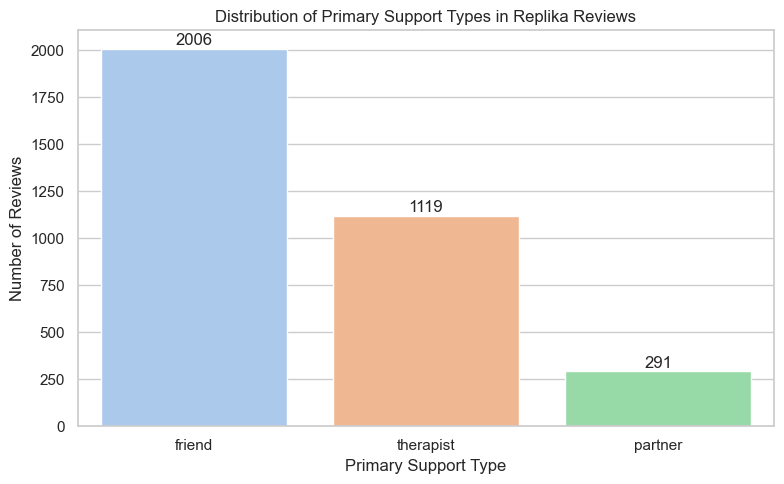

In [12]:
#plotting:
# Set Seaborn style
sns.set(style="whitegrid")

# Create bar plot
plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered, x='primary_support_type', order=['friend', 'therapist', 'partner'], palette="pastel")

# Add count labels on top
for i, count in enumerate(df_filtered['primary_support_type'].value_counts()[['friend', 'therapist', 'partner']]):
    plt.text(i, count + 5, str(count), ha='center', va='bottom')

# Titles and labels
plt.title("Distribution of Primary Support Types in Replika Reviews")
plt.xlabel("Primary Support Type")
plt.ylabel("Number of Reviews")
plt.tight_layout()

# Show plot
plt.show()

## Step 3: Extract Key Entities for Each Group

For each subgroup:
- Apply **spaCy's dependency parser** to extract **subjects** and **objects** (the nouns being discussed or acted upon).
- Apply **TF-IDF weighting** using `TfidfVectorizer` from `scikit-learn` to identify the **top 100 most distinctive entities** per group.
- Manually curate the final entity list for each group (e.g., removing noise or merging synonyms).


### Step 3.1: Apply **spaCy's dependency parser** to extract **subjects** and **objects** (the nouns being discussed or acted upon).



In [ ]:
from collections import Counter
from tqdm import tqdm

# Subset to relevant column
texts = df_filtered['text'].dropna().tolist()

# Initialize containers
subjects_objects = []

# Loop through each review
for doc in tqdm(nlp.pipe(texts, disable=["ner", "textcat"]), total=len(texts)):
    for token in doc:
        if token.dep_ in ["nsubj", "dobj", "pobj"] and token.pos_ == "NOUN":
            subjects_objects.append(token.lemma_.lower())

# Count most common terms
term_freq = Counter(subjects_objects)
top_terms = term_freq.most_common(100)

100%|██████████| 3416/3416 [01:03<00:00, 54.11it/s] 


,term,frequency
0,app,3448
1,friend,1518
2,thing,1332
3,conversation,1127
4,time,967
5,people,920
6,person,557
7,life,517
8,day,476
9,replika,476


In [14]:
# Convert to DataFrame for inspection
import pandas as pd
top_terms_df = pd.DataFrame(top_terms, columns=["term", "frequency"])
top_terms_df.head(100)

,term,frequency
0,app,3448
1,friend,1518
2,thing,1332
3,conversation,1127
4,time,967
...,...,...
95,creator,73
96,technology,73
97,moment,71
98,ad,70


### Step 3.2: Apply **TF-IDF weighting** using `TfidfVectorizer` from `scikit-learn` to identify the **top 100 most distinctive entities** within each group.

### Step 3.3: Manually select final entity list for each subgroup necessary for AnthroScore
--> This should align with the three subgroups

## Step 4: Apply get_anthroscore.py from myracheng (GitHub)

## Step 5: Perform Group-Based Linguistic Profiling

For each support group:
- **Sentiment Analysis** using **VADER** to compute polarity scores per review.
- **Pronoun Analysis**: Calculate the frequency ratio of human-like pronouns (he, she, etc.) vs. object pronouns (it, its).
- **Named Entity Recognition (NER)**: Identify names, roles, or titles assigned to the AI (e.g., “James”, “my therapist”).
- **Additional features**:  
  - Average review length  
  - Most distinctive words via TF-IDF  
  - Most common `coherence_and_clarity_of_review` score

## Step 6: Correlate Linguistic Profiles with Psychological Outcomes
Ordinal GLM or similar approach